In [ ]:
import os
from tensorflow.keras import utils
from tensorflow.keras import layers
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os

In [ ]:

# location of data
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'

# download the data and extract it
path_to_zip = utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)

# construct paths
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

# parameters for datasets
BATCH_SIZE = 32
IMG_SIZE = (160, 160)

# construct train and validation datasets
train_dataset_pre = utils.image_dataset_from_directory(train_dir,
                                                   shuffle=True,
                                                   batch_size=BATCH_SIZE,
                                                   image_size=IMG_SIZE)

validation_dataset_pre = utils.image_dataset_from_directory(validation_dir,
                                                        shuffle=True,
                                                        batch_size=BATCH_SIZE,
                                                        image_size=IMG_SIZE)

# construct the test dataset by taking every 5th observation out of the validation dataset
val_batches = tf.data.experimental.cardinality(validation_dataset_pre)
test_dataset_pre = validation_dataset_pre.take(val_batches // 5)
validation_dataset = validation_dataset_pre.skip(val_batches // 5)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset_pre.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset_pre.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset_pre.prefetch(buffer_size=AUTOTUNE)

# **Function for Two Row Visualization**

In [ ]:
def visualize(train_dataset):
    class_names = train_dataset_pre.class_names
    plt.figure(figsize=(10, 10))

    # Select only the cat images
    cat_images = []
    for images, labels in train_dataset:
        cat_images.extend(images[labels == 0][:3])  # Assuming cats have label 0
        if len(cat_images) == 3:
            break

    # Select only the dog images
    dog_images = []
    for images, labels in train_dataset:
        dog_images.extend(images[labels == 1][:3])  # Assuming dogs have label 1
        if len(dog_images) == 3:
            break

    # Display the cat images
    for i, image in enumerate(cat_images):
        ax = plt.subplot(2, 3, i + 1)
        plt.imshow(image.numpy().astype("uint8"))
        plt.title(class_names[0])  # Assuming cats have label 0
        plt.axis("off")

    # Display the dog images
    for i, image in enumerate(dog_images):
        ax = plt.subplot(2, 3, 3 + i + 1)
        plt.imshow(image.numpy().astype("uint8"))
        plt.title(class_names[1])  # Assuming dogs have label 1
        plt.axis("off")

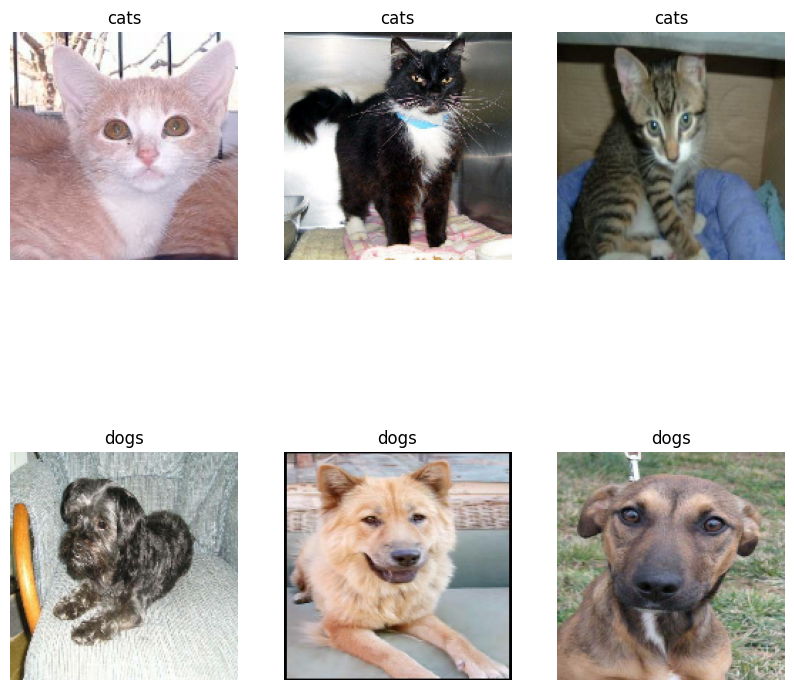

In [ ]:
visualize(train_dataset_pre)

# **Baseline Model**

In [ ]:
labels_iterator= train_dataset.unbatch().map(lambda image, label: label).as_numpy_iterator()
catcount = 0
dogcount = 0
for label in labels_iterator:
    if label == 0:
        catcount += 1
    elif label == 1:
        dogcount += 1

print(f"cats = {catcount} and dogs = {dogcount}")



cats = 1000 and dogs = 1000


Since there are an equal amount of cats and dogs images, we would say that our baseline model is right 50% of the time, regardless of if we are choosing "cats" or "dogs" as the most frequent label.

#Model 1

Epoch 1/20
63/63 [==============================] - 6s 79ms/step - loss: 9.0250 - accuracy: 0.5030 - val_loss: 0.7865 - val_accuracy: 0.5340
Epoch 2/20
63/63 [==============================] - 8s 118ms/step - loss: 0.5940 - accuracy: 0.6815 - val_loss: 0.8079 - val_accuracy: 0.5600
Epoch 3/20
63/63 [==============================] - 7s 101ms/step - loss: 0.4430 - accuracy: 0.7770 - val_loss: 0.9329 - val_accuracy: 0.5520
Epoch 4/20
63/63 [==============================] - 6s 84ms/step - loss: 0.4005 - accuracy: 0.8200 - val_loss: 1.0154 - val_accuracy: 0.5750
Epoch 5/20
63/63 [==============================] - 3s 50ms/step - loss: 0.3267 - accuracy: 0.8605 - val_loss: 1.0652 - val_accuracy: 0.5930
Epoch 6/20
63/63 [==============================] - 4s 54ms/step - loss: 0.2736 - accuracy: 0.8845 - val_loss: 1.5061 - val_accuracy: 0.6130
Epoch 7/20
63/63 [==============================] - 3s 50ms/step - loss: 0.1719 - accuracy: 0.9285 - val_loss: 1.9958 - val_accuracy: 0.5860
Epoch 8/20


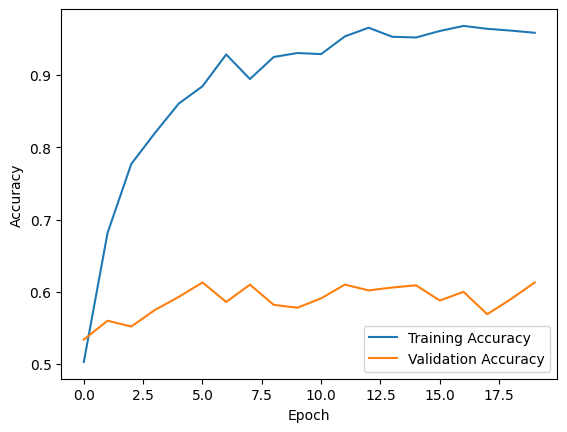

In [ ]:
#Useful Plotting of Model Training Function
def plot_history(history):
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

# Create the model
model1 = tf.keras.models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dropout(0.3),
    layers.Dense(10)
])

# Compile the model
model1.compile(optimizer='adam',
               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
               metrics=['accuracy'])

# Train the model
history = model1.fit(train_dataset,
                     epochs=20,
                     validation_data=validation_dataset)

# Plot the history
plot_history(history)

The accuracy of my model stabilized between 55% and 60% during training, this is obviously only slightly better than the 50% that we had in the baseline model.

# Model with Data Augmentation
## RandomFlip layer


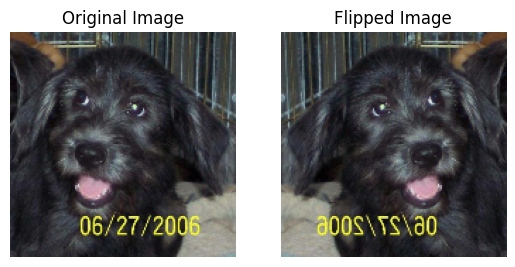

In [ ]:
# Normalize pixel values of the images
train_dataset_im = train_dataset.map(lambda image, label: (image / 255.0, label))
validation_dataset_im = validation_dataset.map(lambda image, label: (image / 255.0, label))

# Create the flip layer
flip_layer = tf.keras.layers.RandomFlip('horizontal')

# Example image for visualization
image = next(iter(train_dataset_im))[0][0]

# Apply RandomFlip to image
flipped_image = flip_layer(image)

# Plot original image and flipped image
fig, axes = plt.subplots(1, 2)
axes[0].imshow(image)
axes[0].set_title("Original Image")
axes[0].axis("off")
axes[1].imshow(flipped_image)
axes[1].set_title("Flipped Image")
axes[1].axis("off")
plt.show()

##Random Rotation Layer

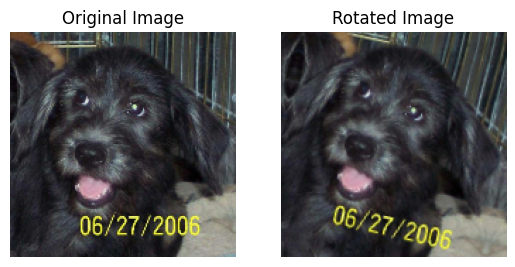

In [ ]:
# Create the rotation layer
rotation_layer = tf.keras.layers.RandomRotation(factor=0.3)

# Apply RandomRotation to image
rotated_image = rotation_layer(image)

# Plot original image and rotated image
fig, axes = plt.subplots(1, 2)
axes[0].imshow(image)
axes[0].set_title("Original Image")
axes[0].axis("off")
axes[1].imshow(rotated_image)
axes[1].set_title("Rotated Image")
axes[1].axis("off")
plt.show()

## Augmented Model

Epoch 1/20
63/63 [==============================] - 5s 52ms/step - loss: 18.0312 - accuracy: 0.5140 - val_loss: 0.7658 - val_accuracy: 0.5790
Epoch 2/20
63/63 [==============================] - 5s 74ms/step - loss: 0.7858 - accuracy: 0.5235 - val_loss: 0.7359 - val_accuracy: 0.5860
Epoch 3/20
63/63 [==============================] - 4s 51ms/step - loss: 0.7489 - accuracy: 0.5510 - val_loss: 0.7611 - val_accuracy: 0.5800
Epoch 4/20
63/63 [==============================] - 4s 55ms/step - loss: 0.7404 - accuracy: 0.5670 - val_loss: 0.6827 - val_accuracy: 0.6110
Epoch 5/20
63/63 [==============================] - 4s 64ms/step - loss: 0.7129 - accuracy: 0.5745 - val_loss: 0.7014 - val_accuracy: 0.6010
Epoch 6/20
63/63 [==============================] - 4s 51ms/step - loss: 0.7236 - accuracy: 0.5690 - val_loss: 0.6970 - val_accuracy: 0.6020
Epoch 7/20
63/63 [==============================] - 3s 51ms/step - loss: 0.7338 - accuracy: 0.5670 - val_loss: 0.7010 - val_accuracy: 0.5780
Epoch 8/20
6

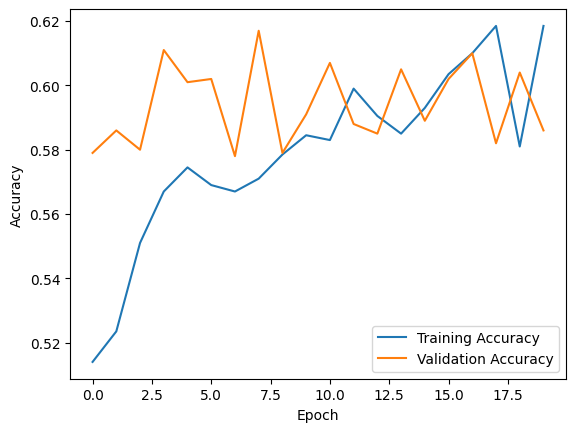

In [ ]:
# Create the model
model1 = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(factor=0.3),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dropout(0.3),
    layers.Dense(10)
])

# Compile the model
model1.compile(optimizer='adam',
               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
               metrics=['accuracy'])

# Train the model
history = model1.fit(train_dataset,
                     epochs=20,
                     validation_data=validation_dataset)

# Plot the history
plot_history(history)

Here on the Data "Augmentation" model, it looks like are actually getting marginally worse results. The reason for this is that, likely, flipping and rotating the images is hindering the models "learning ability", since most of the data is in a normal position.

# Data Preprocessing Model

Here we are preprocessing the data using the "MobileNet_V2" preprocess function.

Epoch 1/20
63/63 [==============================] - 6s 72ms/step - loss: 0.7367 - accuracy: 0.5495 - val_loss: 0.6327 - val_accuracy: 0.6210
Epoch 2/20
63/63 [==============================] - 3s 51ms/step - loss: 0.6464 - accuracy: 0.6315 - val_loss: 0.6210 - val_accuracy: 0.6450
Epoch 3/20
63/63 [==============================] - 4s 54ms/step - loss: 0.6199 - accuracy: 0.6495 - val_loss: 0.6188 - val_accuracy: 0.6620
Epoch 4/20
63/63 [==============================] - 4s 62ms/step - loss: 0.6089 - accuracy: 0.6695 - val_loss: 0.6294 - val_accuracy: 0.6560
Epoch 5/20
63/63 [==============================] - 3s 52ms/step - loss: 0.6083 - accuracy: 0.6735 - val_loss: 0.5925 - val_accuracy: 0.6850
Epoch 6/20
63/63 [==============================] - 3s 51ms/step - loss: 0.5877 - accuracy: 0.6755 - val_loss: 0.5758 - val_accuracy: 0.6900
Epoch 7/20
63/63 [==============================] - 4s 66ms/step - loss: 0.5618 - accuracy: 0.7065 - val_loss: 0.5692 - val_accuracy: 0.7000
Epoch 8/20
63

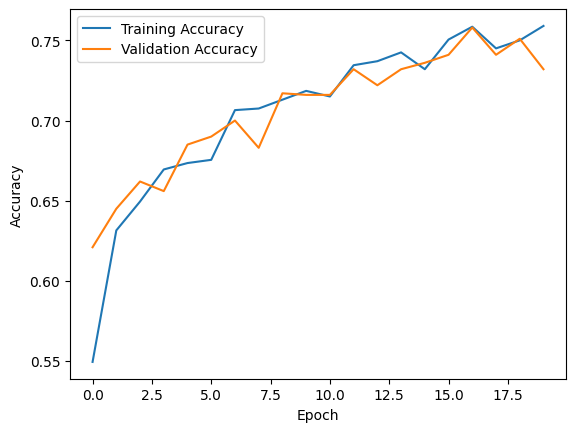

In [ ]:
i = tf.keras.Input(shape=IMG_SIZE + (3,))
x = tf.keras.applications.mobilenet_v2.preprocess_input(i)
preprocessor = tf.keras.Model(inputs = [i], outputs = [x])

# Create the model with the preprocessor as the first layer
model3 = tf.keras.Sequential([
    preprocessor,
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(factor=0.3),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dropout(0.3),
    layers.Dense(10)])

#Compile the model
model3.compile(optimizer='adam',
               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
               metrics=['accuracy'])

# Train the model
history = model3.fit(train_dataset,
                     epochs=20,
                     validation_data=validation_dataset)

# Plot the history
plot_history(history)

As you can see with results ~73% this preprocessing really does help the data. We are getting much higher results than ~55% from before.

# **Importing the model for transfer learning "MobileNetV2"**

Epoch 1/20
63/63 [==============================] - 11s 121ms/step - loss: 0.4005 - accuracy: 0.8780 - val_loss: 0.0808 - val_accuracy: 0.9700
Epoch 2/20
63/63 [==============================] - 4s 55ms/step - loss: 0.0684 - accuracy: 0.9725 - val_loss: 0.0738 - val_accuracy: 0.9720
Epoch 3/20
63/63 [==============================] - 4s 55ms/step - loss: 0.0453 - accuracy: 0.9810 - val_loss: 0.0603 - val_accuracy: 0.9700
Epoch 4/20
63/63 [==============================] - 5s 71ms/step - loss: 0.0281 - accuracy: 0.9900 - val_loss: 0.0537 - val_accuracy: 0.9830
Epoch 5/20
63/63 [==============================] - 4s 54ms/step - loss: 0.0193 - accuracy: 0.9915 - val_loss: 0.0579 - val_accuracy: 0.9760
Epoch 6/20
63/63 [==============================] - 4s 54ms/step - loss: 0.0145 - accuracy: 0.9955 - val_loss: 0.0854 - val_accuracy: 0.9690
Epoch 7/20
63/63 [==============================] - 5s 71ms/step - loss: 0.0101 - accuracy: 0.9975 - val_loss: 0.0532 - val_accuracy: 0.9820
Epoch 8/20


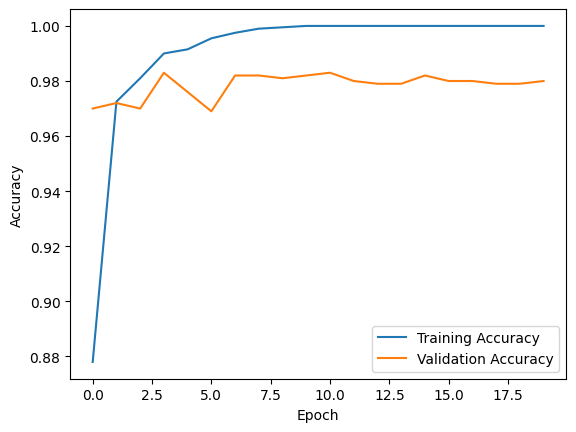

In [ ]:

base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SIZE + (3,),
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False

i = tf.keras.Input(shape=IMG_SIZE + (3,))
x = base_model(i, training = False)
base_model_layer = tf.keras.Model(inputs = [i], outputs = [x])

# Create the model with the preprocessor as the first layer, then using MobileNet
model4 = tf.keras.Sequential([
    preprocessor,
    base_model_layer,
    layers.GlobalMaxPooling2D(),
    layers.Dense(2)
])

# Compile the model
model4.compile(optimizer='adam',
               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
               metrics=['accuracy'])

# Train the model
history = model4.fit(train_dataset,
                     epochs=20,
                     validation_data=validation_dataset)

plot_history(history)

As you can see, using other models that have been well tuned and designed can lead to much better outcomes. Using the MobileNet_V2 model, we can easily get an extremely high competency model just by importing this as a layer. We can then add subsequent layers as needed to suit the specific needs of our project. Thanks!